In [1]:
# Implemented by Hu Junfeng
# Time: 28/02/2022

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from flows import PlanarFlow, RadialFlow
from torch.distributions import MultivariateNormal
from tqdm import tqdm
from visualization import plot_function, plot_model_hist
from train import train_energy

### Define energy functions in the paper

In [2]:
w1 = lambda x: torch.sin(2 * np.pi * x[:, 0] / 4)
w2 = lambda x: 3 * torch.exp(-0.5 * ((x[:, 0] - 1) / 0.6) ** 2)
w3 = lambda x: 3 * torch.sigmoid((x[:, 0] - 1) / 0.3)

def u1(z):
    """
    :param z: The first dimension means batch
    :return: value of the function
    """
    return 0.5 * ((torch.norm(z, 2, dim=1) - 2) / 0.4) ** 2 \
           - torch.log(torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2)
                      + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2))

def u2(z):
    return 0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2

def u3(z):
    return -torch.log(torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2) +
                      torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2))

def u4(z):
    return -torch.log(torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2) +
                      torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2))

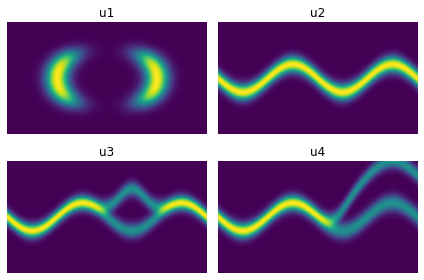

In [3]:
fig, axes = plt.subplots(2, 2)
for U, ax in zip([u1, u2, u3, u4], axes.flatten()):
    plot_function(U, ax)
    ax.set_title(U.__name__)
    ax.axis('off')

fig.tight_layout()
plt.show()

In [3]:
# Hyperparameters
num_flow = 32
z_dim = 2
iteration = 5000
batch_size = 512

### Train the model

In [5]:
planar_model_list = []
for U in [u1, u2, u3, u4]:
    model = nn.ModuleList([PlanarFlow(z_dim) for i in range(num_flow)])
    planar_model_list.append(train_energy(U, model, z_dim, batch_size))

Loss -2.924996: 100%|██████████| 5000/5000 [01:57<00:00, 42.52it/s]


Sampling: 100%|██████████| 10/10 [02:34<00:00, 15.43s/it]


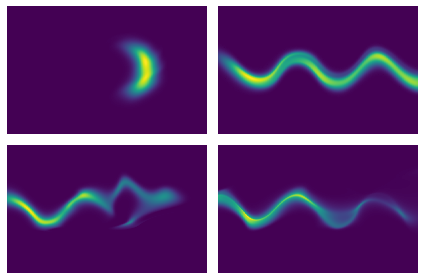

In [8]:
fig, axes = plt.subplots(2, 2)
for model, ax in zip(planar_model_list, axes.flatten()):
    plot_model_hist(model, ax, z_dim=z_dim, batch_size=1000000)
    ax.axis('off')

fig.tight_layout()
plt.show()

In [4]:
radial_model_list = []
for U in [u1, u2, u3, u4]:
    model = nn.ModuleList([RadialFlow(z_dim) for i in range(num_flow)])
    radial_model_list.append(train_energy(U, model, z_dim, batch_size))

Loss nan: 100%|██████████| 5000/5000 [01:47<00:00, 46.68it/s]


In [5]:
for idx, model in enumerate(radial_model_list):
    torch.save(model.state_dict(), f"radial-model{idx}.pth")

In [7]:
model = nn.ModuleList([RadialFlow(z_dim) for i in range(num_flow)])
radial_model_list[2] = train_energy(u3, model, z_dim, batch_size)

Loss nan: 100%|██████████| 5000/5000 [01:50<00:00, 45.05it/s]


Sampling:   0%|          | 0/10 [00:00<?, ?it/s]


ValueError: cannot convert float NaN to integer

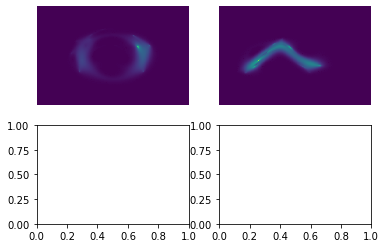

In [8]:
fig, axes = plt.subplots(2, 2)
for model, ax in zip(radial_model_list, axes.flatten()):
    plot_model_hist(model, ax, z_dim=z_dim, batch_size=100000)
    ax.axis('off')

fig.tight_layout()
plt.show()